In [3]:
%matplotlib inline 
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D
import pymc as pm

In [4]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


In [5]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("fivethirtyeight")

### Model

\begin{align*}
    y_t &= \rho_0 + \rho_1 y_{t-1}  + \epsilon_t, \quad t=0, 1, \dots, T; \\
    \epsilon_t &\overset{iid}{\sim} \mathcal{N}(0, \sigma^2)
\end{align*}

In [6]:
def AR1(theta: torch.Tensor, T=100, burn_in=0) -> torch.Tensor:
    '''
    Simulates from an AR(2) process:

    y[t] = rho0 + rho1 * y[t-1]  + eps[t]
    eps[t] ~ N(0, sigma^2) 

    Input: theta = [rho0, rho1, sigma]

    Output: Y_T = 
    '''
    # drift +  innovation terms
    y = torch.zeros((theta.size(0), T + burn_in))
    # y[0]
    y[...,0] = D.Normal(loc=0.0, scale=theta[...,2]).sample()
    # y[t]    
    for t in range(1, T + burn_in):
        y[...,t] = D.Normal(loc=theta[...,0] + theta[...,1] * y[...,t-1], scale=theta[...,2]).sample() 
    
    return y[...,burn_in:]

### Prior

\begin{align*}
    \rho_0 &\sim \mathcal{N}(0, 5^2)\\
    \rho_1 &\sim \mathcal{U}(-1, 1)\\
    \sigma &\sim \mathrm{HalfNormal}(3)
\end{align*}

In [7]:
def Prior(n_samples=1):
    rho0 = D.Normal(loc=0., scale=5.).sample((n_samples,))
    rho1 = D.Uniform(low=-1., high=1.).sample((n_samples,))
    sigma = D.HalfNormal(scale=3.).sample((n_samples,))

    theta = torch.stack([rho0, rho1, sigma], dim=-1)

    return theta

### viz

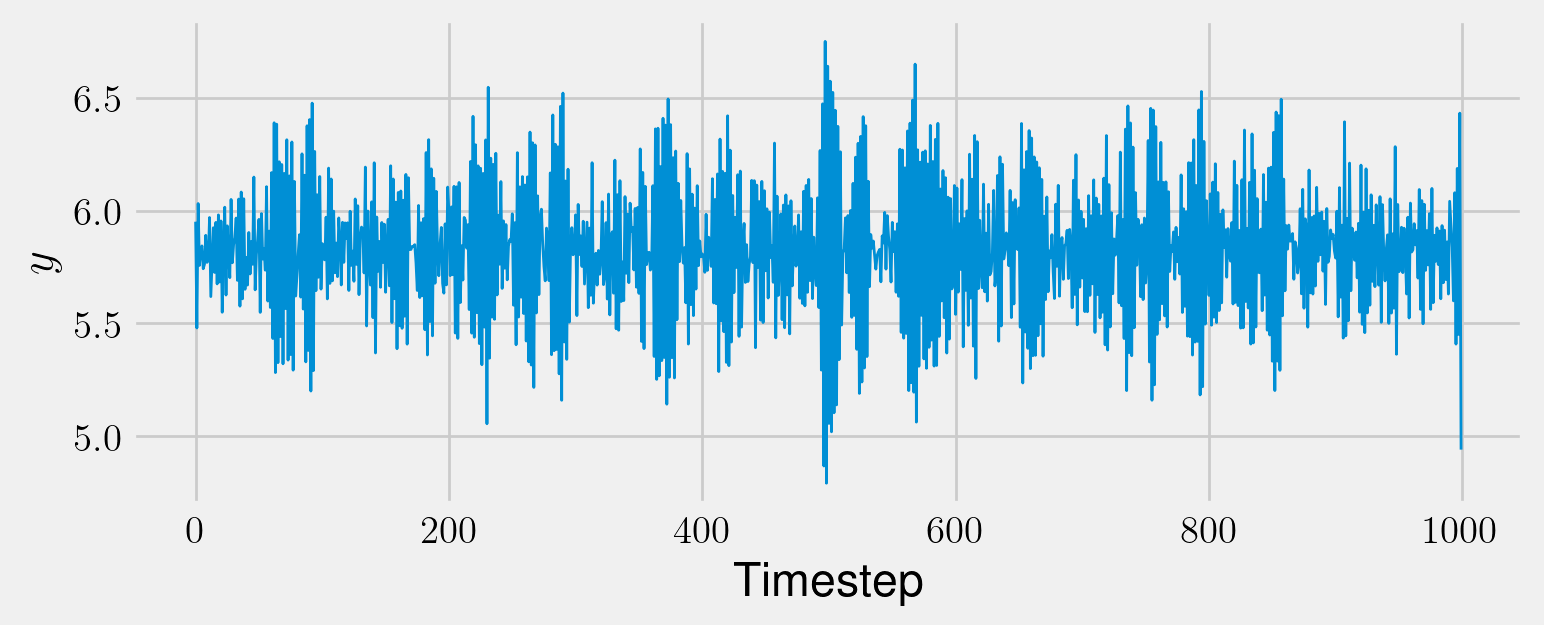

In [8]:
#theta = torch.tensor([[-10.0, 0.7,  2.0]])
theta = Prior(n_samples=1)
y = AR1(theta=theta, T=1000, burn_in=500)

plt.figure(figsize=(8,3))
plt.plot(y.squeeze(), lw=1)
plt.xlabel("Timestep")
plt.ylabel("$y$");

### Amortized VI

In [22]:
import torch.nn as nn
class LSTMNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64, num_hd=1):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 

        # lstm layer
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=64, num_layers=num_hd, batch_first=True)

        # fully connected hidden layer
        self.fc = nn.Sequential(
            nn.Linear(64, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # lstm & hidden layers
        x, _ = self.lstm(x)
        x = x[:,-1,:]   # extract final time step
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
    

def transform_data(data, period_length):
    dataset = data.clone()
    
    dataset[...,1:] = data[...,1:] - data[...,:-1]
    #dataset = dataset.sort(dim=-1).values
    #dataset = (dataset - dataset.mean(dim=0).unsqueeze(1)) / dataset.std(dim=-1).unsqueeze(1)
    Y = []

    for i in range(dataset.size(1) // period_length):
        period = dataset[...,i*period_length:(i*period_length + period_length)]
        Y.append(period)
    
    return torch.stack(Y, dim=1)
        

### training

In [23]:
import pyvi.utils.HelperFunc as hf
import pyvi.utils.GMMLossFunc as lf

Epoch 1 Loss 4.251433518648148 

Epoch 2 Loss 3.9980620606541635 

Epoch 3 Loss 3.418814620018005 

Epoch 4 Loss 3.0507167205691337 

Epoch 5 Loss 2.7571555624127386 

Epoch 6 Loss 2.6252004800081252 

Epoch 7 Loss 2.5703925283491613 

Epoch 8 Loss 2.5412384584367276 

Epoch 9 Loss 2.516979570221901 

Epoch 10 Loss 2.5029375769853592 

Epoch 11 Loss 2.494381039261818 

Epoch 12 Loss 2.473344246137142 

Epoch 13 Loss 2.481056184500456 

Epoch 14 Loss 2.468225272408128 

Epoch 15 Loss 2.448467295151949 

Epoch 16 Loss 2.439926224064827 

Epoch 17 Loss 2.4355836567014455 

Epoch 18 Loss 2.4224337844640016 

Epoch 19 Loss 2.42251724614501 

Epoch 20 Loss 2.4070895107120274 

Epoch 21 Loss 2.4086659037977456 

Epoch 22 Loss 2.397195562636852 

Epoch 23 Loss 2.3922572332501413 

Epoch 24 Loss 2.383221531456709 

Epoch 25 Loss 2.3786092842668296 

Epoch 26 Loss 2.3824205645293 

Epoch 27 Loss 2.367376009711623 

Epoch 28 Loss 2.360819562458992 

Epoch 29 Loss 2.356606234505773 

Epoch 30 Loss

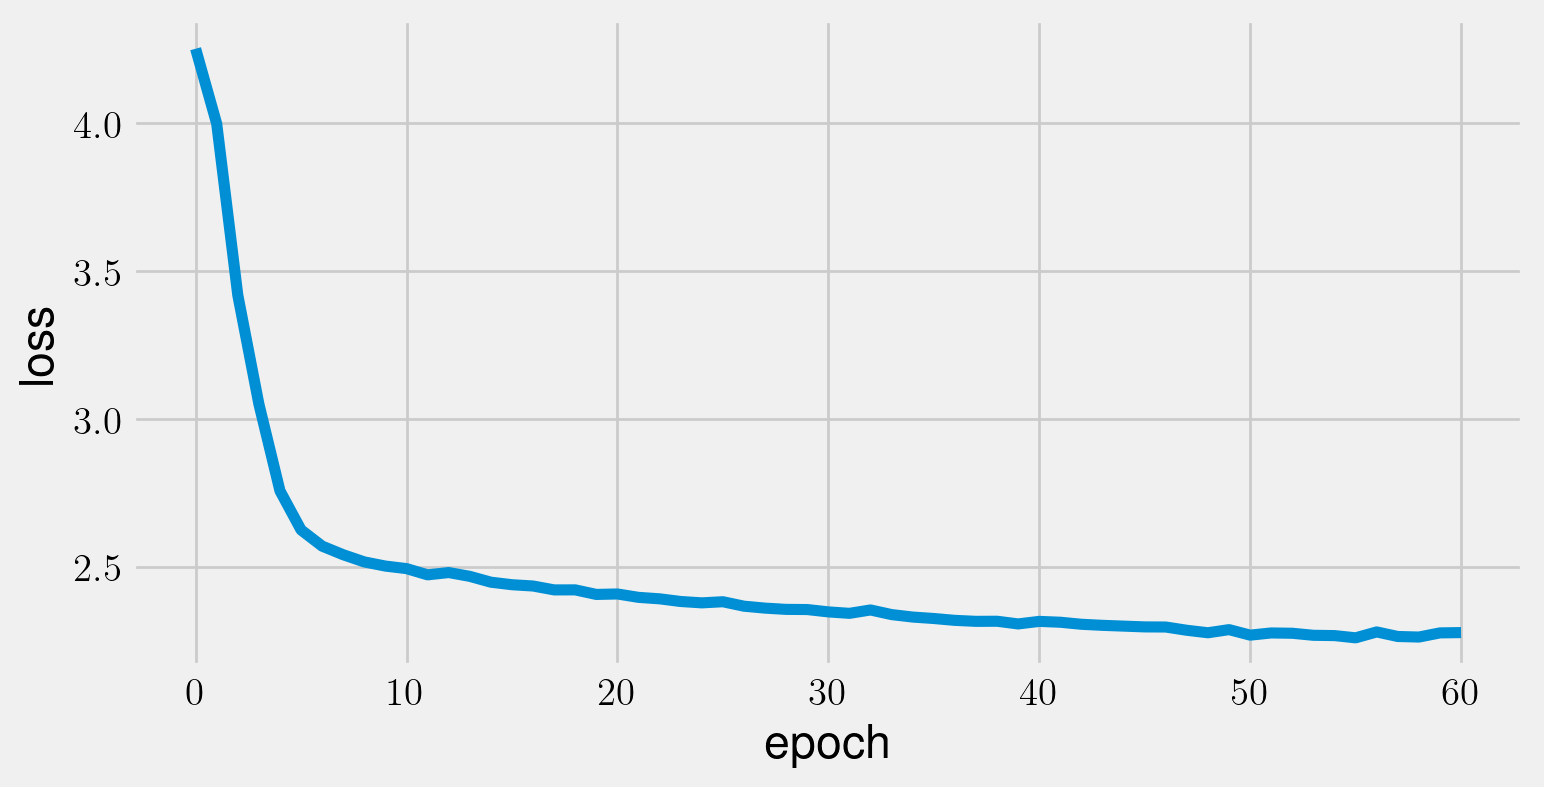

In [24]:
#Explicitly provided seeds for training process
random_seed = 1234
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, burn_in, period_length, batchsize = 10000, 100, 200, 25, 200

# sample parameter values from the specified prior
Theta_train =  Prior(n_samples=n_prior)

# draw samples from the simulator conditioned on parameter values
Y_train = AR1(Theta_train, T=n_obs, burn_in=burn_in)
Y_train = transform_data(Y_train, period_length=period_length)

# put rho1 on `logit` scale
Theta_train[...,1] = torch.log((1 + Theta_train[...,1]) / (1 - Theta_train[...,1]))
# # put sigma on log-scale
Theta_train[...,2] = Theta_train[...,2].log()

# standardize parameters
mean_param, std_param =  Theta_train.mean(dim=0), Theta_train.std(dim=0)
Theta_train = (Theta_train - mean_param) / std_param

# # create a combined dataset and data loader
data_train = torch.utils.data.TensorDataset(Y_train, Theta_train)
data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)

# Neural net
gmmnet = LSTMNet(input_size=period_length, dim=3, K=2, hd=128, num_hd=2).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
gmmnet = hf.nn_optimizer(model=gmmnet, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=1e-4,
                       eps=0.001, 
                       max_epochs=400,
                       verbose=True,
                       echo_after=1,
                       path='trained_models/ar/ar_lstm_pymc.pt'
                      )

#gmmnet = torch.load('trained_models/ar/ar_lstm_pymc_toprior.pt')

## Evaluation

In [25]:
labels = [r'$\rho_0$', r'$\rho_1$', r'$\sigma$']
varnames = ['rho0', 'rho1', 'sigma']

#### 1. generate synthetic data

In [13]:
theta  = torch.tensor([[10., 0.5, 1.0]])
theta = Prior()

y = AR1(theta, n_obs, burn_in=burn_in)
yobs  = y.clone()

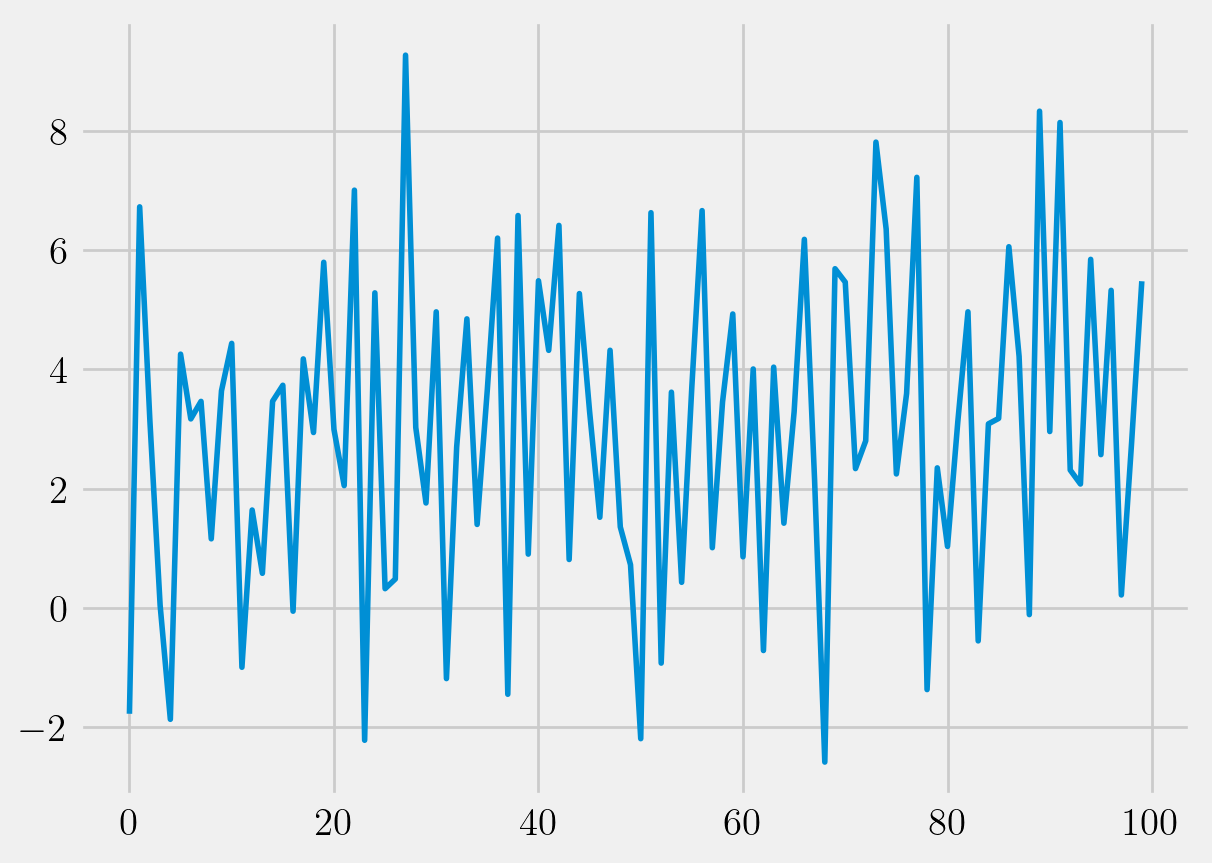

In [14]:
plt.plot(yobs.squeeze(),lw=2);

#### 2. posterior sampling (NUTS sampler)

In [15]:
import pytensor.tensor as pt

with pm.Model() as ar1:
    rho0 = pm.Normal("rho0", mu=0.0, sigma=2.0)
    rho1 = pm.Uniform("rho1", -1, 1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y",
        rho=pt.stack([rho0, rho1]),
        sigma=sigma,
        constant=True,
        init_dist=pm.Normal.dist(0, 100),
        observed=yobs.squeeze(),
    )

    idata = pm.sample(
        1000,
        tune=2000,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho0, rho1, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 56 seconds.


#### 3. NPE approximation

In [26]:
y = transform_data(yobs, period_length=period_length)

# run the gmmnet
with torch.no_grad():
    mean, chol, coeff = gmmnet(y.to(device))

n_sim, n_component, dim = mean.shape[0], mean.shape[1], mean.shape[2]

# calculate Cholesky factors
chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

# # caclulate precision matrices
precision = chol @ chol.transpose(2, 3)

# # calculate covariance matrices
covariance = torch.linalg.inv(precision) 

# mixture weights
mix = D.Categorical(coeff)

#### 4. visualization

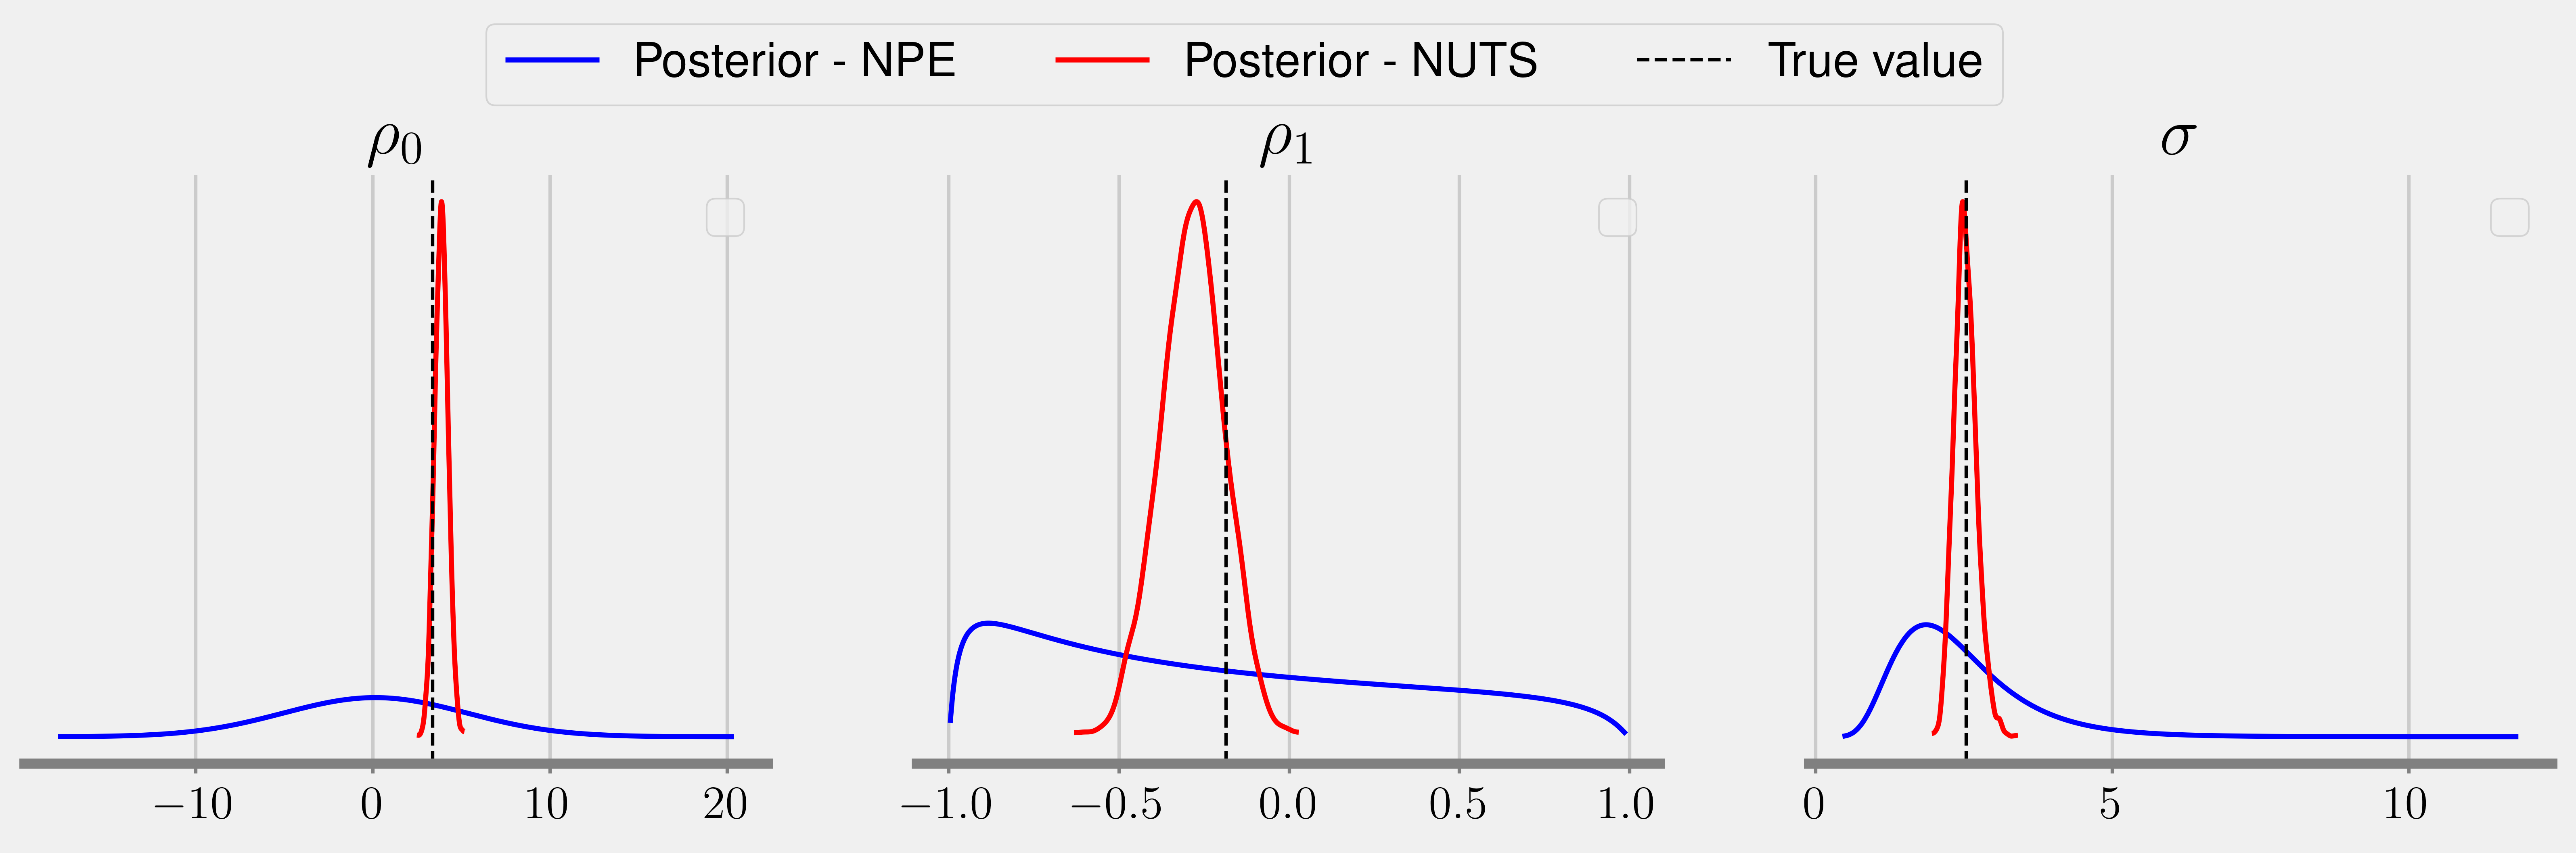

In [27]:
N = 10000

# plotting
fig, ax = plt.subplots(1, dim, figsize=(12,3), dpi=300)

for k in range(dim):
    # mixture components
    comp = D.Normal(loc=mean[:,:,k], scale=torch.sqrt(covariance[:,:,k,k]))
    # define the mixture
    gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(loc=mean[:,:,k].squeeze(), scale=torch.sqrt(covariance[:,:,k,k].squeeze()))

    # draw samples from the approximate posterior
    theta_k_sd = gmm.sample((N,)).squeeze().sort().values 
    theta_k = (theta_k_sd * std_param[k] + mean_param[k]).cpu().sort().values      # put on unnormalized scale
    pdf = gmm.log_prob(theta_k_sd).exp().cpu() / std_param[k]

    # logit(rho1) ---> rho1
    if k==1:
        theta_k = (theta_k.exp() - 1) / (theta_k.exp() + 1)
        pdf = pdf * 2 / abs(1 - theta_k**2)
    
    # log(sigma) ---> sigma
    if k == 2:
        theta_k = theta_k.exp()
        pdf = pdf / abs(theta_k)
        
        
    # true value
    theta_k_true = theta[:,k] 

    
    ax[k].plot(theta_k, pdf, lw=1.5, c='blue',  label='Posterior - NPE')
    az.plot_posterior(idata, hdi_prob='hide', var_names=varnames[k], ax=ax[k],
                       point_estimate=None,  label='Posterior - NUTS', lw=1.5, color="red");
    ax[k].axvline(theta_k_true, ls='--', color='black', lw=1, label='True value')
    
    ax[k].legend([])
    ax[k].set_title(labels[k], fontsize=20)

handles, legend_labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=3, fancybox=True)
#plt.suptitle('AR(1) process: variational posterior')
plt.show()

#fig.savefig(fname="figures/ar1_nodrift2.png", transparent=True, bbox_inches='tight')

### SBC

In [19]:
def sbc_gaussian(gmmnet, n_sim = 1e+4, ecdf=True, ecdf_diff=False, labels=None):
    '''
    Perform simulation-based calibration check for a Gaussian mixture network for posterior approximation

    Input:
        -- gmmnet: Gaussian mixture network, with input size given by `sample_size`
        -- proposal: proposal distribution `theta ~ p(theta)`, usually the same as the prior/proposal distribution used for training
                     Note: must have a `sample()` method
        
        -- generator: function that takes parameter values `theta` as input and generate the corresponding simulator model
                       `x ~ p(x|theta)`  as an instance of a class with a `sample` method
        
        -- sample_size: number of iid samples from `x ~ p(x|theta)` for each values of theta

        -- n_sim: number of simulation from the joint distribution: theta ~ p(theta); x ~ p(x|theta)

        -- ecdf: whether to output an eCDF or a histogram plot, default: ecdf=True

        -- ecdf_diff: whether on the y-axis are the `ecdf(w)` values (if True) or `ecdf(w) - w` values (if False).
                        This is ignored if ecdf=False.
        
        -- logscale: (iterable) contains dimensions of the model parameter vector `theta` that are on log-scale
                        note: we use the standard Python counting, starting at 0

    Note: 95% confidence intervals are based on the  Dvoretzky–Kiefer–Wolfowitz inequality (see https://en.wikipedia.org/wiki/Empirical_distribution_function, accessed: 20-05-2024)
    
    Output: SBC plot as a Pyplot figure
    '''
    # draw samples from the prior/proposal  theta ~ p(theta)
    Theta = Prior(n_sim)

    # draw samples from the model x ~ p(x|theta)
    X = AR1(Theta, n_obs, burn_in)
    X = transform_data(X, period_length=period_length)
    # ensure all dimensions are on the right scale
    # put rho1 on `logit` scale
    Theta[...,1] = torch.log((1 + Theta[...,1]) / (1 - Theta[...,1]))
    # # put sigma on log-scale
    Theta[...,2] = Theta[...,2].log()
    Theta = (Theta - mean_param) / std_param
    #Theta = Theta.clone()
    
    # run the gmmnet
    with torch.no_grad():
        mean, chol, coeff = gmmnet(X.to(device))

    n_component, dim = mean.shape[1], mean.shape[2]

    # calculate Cholesky factors
    chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

    # caclulate precision matrices
    precision = chol @ chol.transpose(2, 3)

    # calculate covariance matrices
    covariance = torch.linalg.inv(precision) 

    # define GMM variational marginal distributions and calculate cdf values for the true parameter values
    
    fig = plt.figure(figsize=(12, 4), dpi=300)

    for j in range(dim):
        # mixture weights
        mix = D.Categorical(coeff)
        # mixture components
        comp = D.Normal(mean[:,:,j], torch.sqrt(covariance[:,:,j,j]))
        # define the mixture
        gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,j].squeeze(), torch.sqrt(covariance[:,:,j,j]).squeeze())
        # evaluate cdf
        w = gmm.cdf(Theta[:,j].to(device)).cpu().squeeze()

        if ecdf:
            #=====================================================
            # ECDF plot
            #=====================================================
            # Calculate the empirical cumulative distribution function (ECDF)
            eCDF = torch.arange(1, n_sim + 1) / n_sim

            # calculate 95% confidence intervals for the eCDF
            eps = np.sqrt(np.log(2 / 0.05) / (2 * n_sim))
            eCDF_lower, eCDF_upper = eCDF - eps, eCDF + eps

            # exact cdf
            x = np.linspace(0, 1, 100)
            w = w.sort().values

            fig.add_subplot(1, dim, j+1)
            if not ecdf_diff:
                # plot eCDF and true CDF values
                plt.step(w, eCDF, lw=1.5)
                plt.plot(x, x, 'k--', lw=1.5)
                # plot 95% confidence bands
                plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)
                plt.ylabel(r'$F_{\omega}$')
            else:
                plt.step(w, eCDF - w, lw=1)
                #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
                plt.ylabel(r'$F_{\omega} - \omega$')

            plt.xlabel(r'$\omega$')
            plt.title(labels[j])
        else:
            #========================================
            # plot histograms
            #========================================
            fig.add_subplot(1, dim, j + 1)
            plt.hist(w, bins=25, density=True, alpha=.6)
            plt.title(labels[j])

    plt.tight_layout()
        
    
    return fig

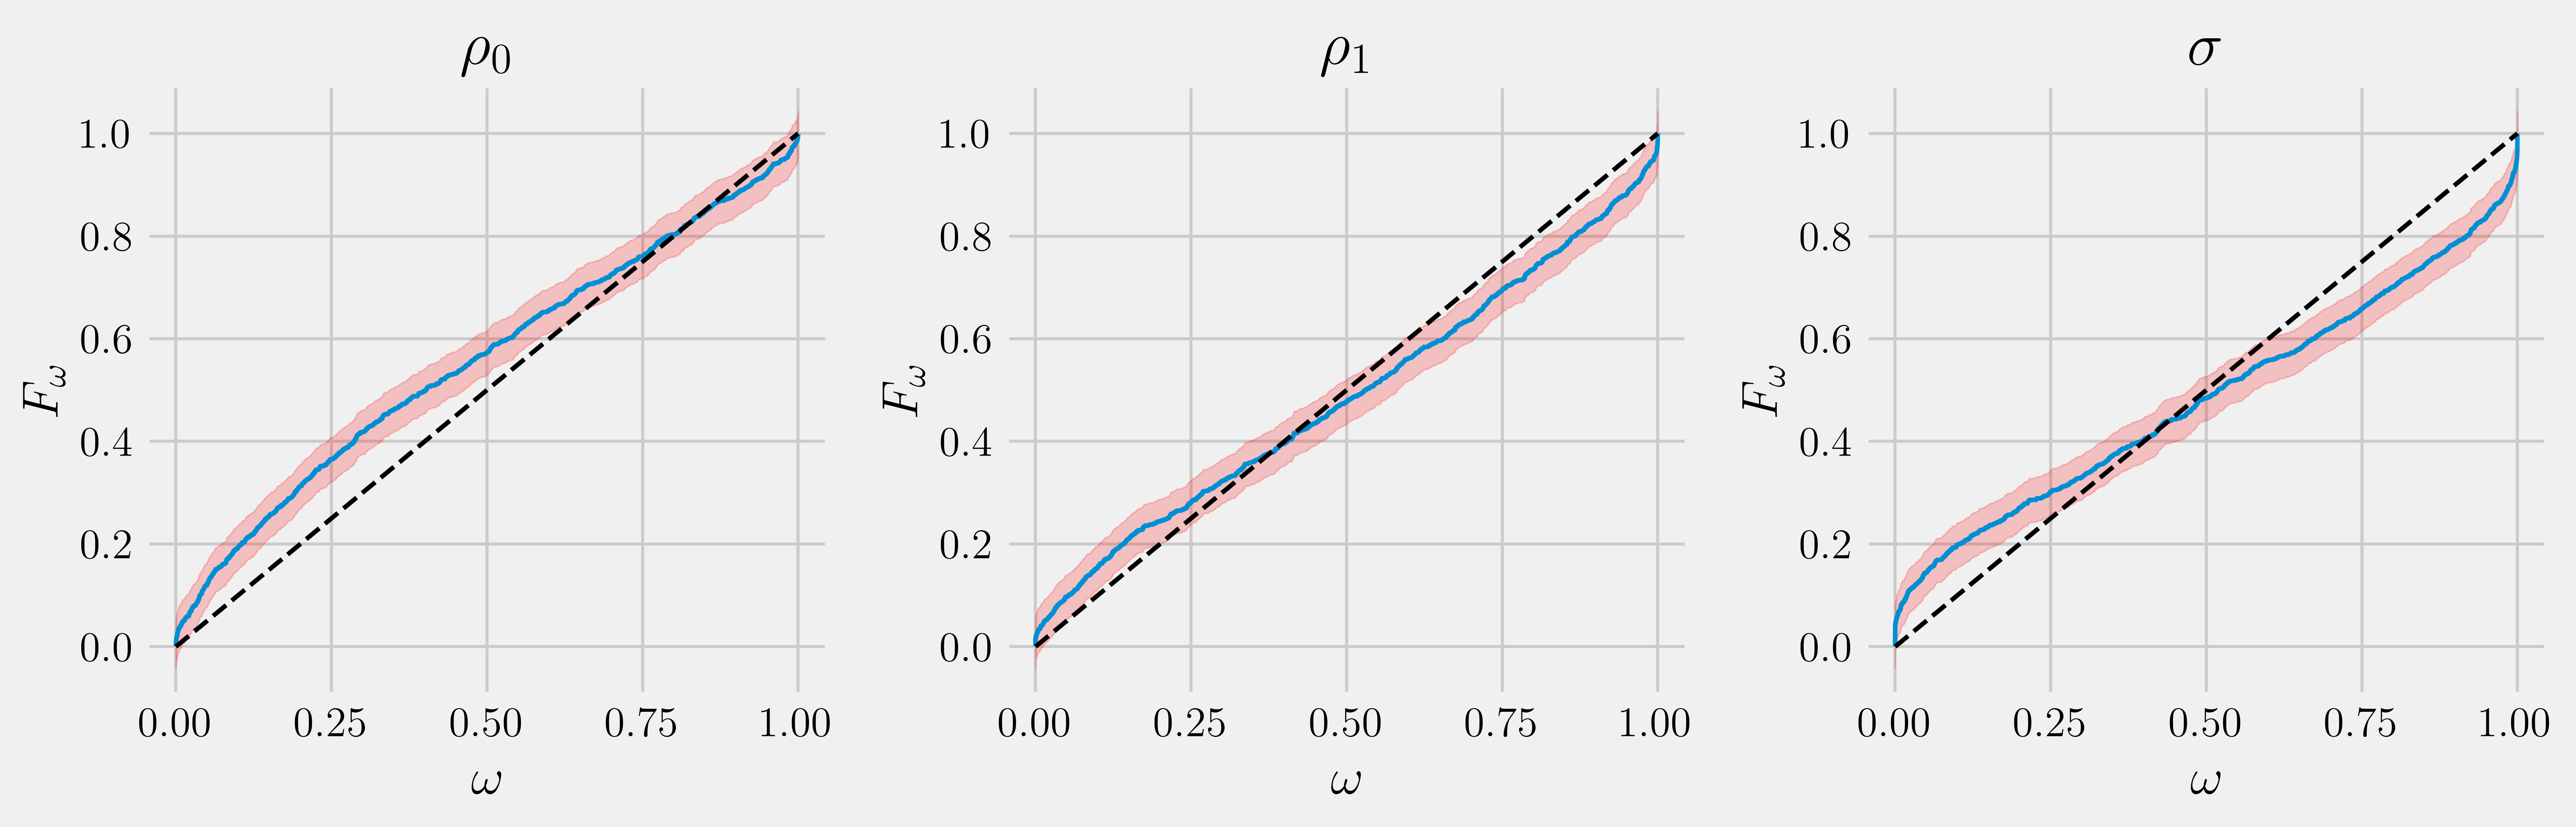

In [21]:
f = sbc_gaussian(gmmnet, 1000, labels=labels)
#f.savefig(fname="figures/ar1_sbc.png", transparent=True, bbox_inches='tight')